In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm
import albumentations as Alb
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

In [ ]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
class Load_ISIC_data(Dataset):
    def __init__(self, i_pth, m_pth, img_size, img_trfm=None):
        self.img_size = img_size
        self.m_pth = m_pth
        self.i_pth = i_pth
        self.trfm = img_trfm
        self.img_ids = [img_file[:-4] for img_file in os.listdir(i_pth) if img_file.endswith('.jpg')]


    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        m_pth = os.path.join(self.m_pth, self.img_ids[idx] + '.png')
        i_pth = os.path.join(self.i_pth, self.img_ids[idx] + '.jpg')

        my_mask = cv2.imread(m_pth, cv2.IMREAD_GRAYSCALE)
        my_image = cv2.imread(i_pth, cv2.IMREAD_COLOR)

        my_image = cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
        _, my_mask = cv2.threshold(my_mask, 127, 255, cv2.THRESH_BINARY)

        if self.trfm is not None:
            augmentations = self.trfm(image=my_image, mask=my_mask)
            my_mask = augmentations['mask']
            my_image = augmentations['image']

        my_mask = torch.from_numpy(my_mask).unsqueeze(0).float()
        my_mask[my_mask == 255.0] = 1.0
        my_image = torch.from_numpy(my_image).permute(2, 0, 1).float() / 255.


        return my_image, my_mask

In [ ]:
class ImageTransforms:
    def __init__(self, size):
        self.size = size

    def __call__(self, image, mask):
        transform = Alb.Compose([
            Alb.Resize(height=self.size, width=self.size),
            Alb.HorizontalFlip(p=0.5),
            Alb.VerticalFlip(p=0.1)
        ])
        augmented = transform(image=image, mask=mask)
        return {'image': augmented['image'], 'mask': augmented['mask']}

In [ ]:
train_img_path = '/kaggle/input/isic-segmentation-2016/ISIC 2016/train/'
train_mask_path = '/kaggle/input/isic-segmentation-2016/ISIC 2016/train_masks/'

test_img_path = '/kaggle/input/isic-segmentation-2016/ISIC 2016/test/'
test_mask_path = '/kaggle/input/isic-segmentation-2016/ISIC 2016/test_masks/'

size= 128
img_transforms = ImageTransforms(size=size)
train_dataset = Load_ISIC_data(i_pth=train_img_path, m_pth=train_mask_path, img_size=size, img_trfm=img_transforms)
test_dataset = Load_ISIC_data(i_pth=test_img_path, m_pth=test_mask_path, img_size=size, img_trfm=img_transforms)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                          num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

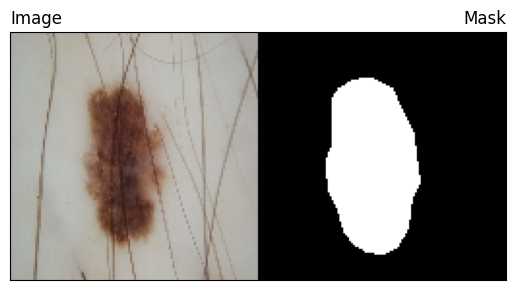

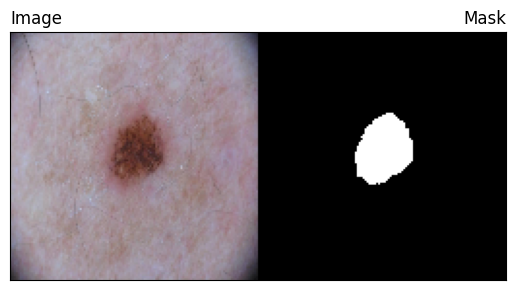

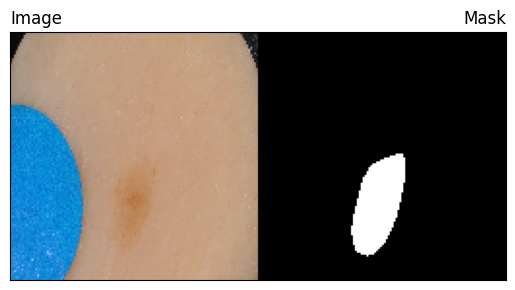

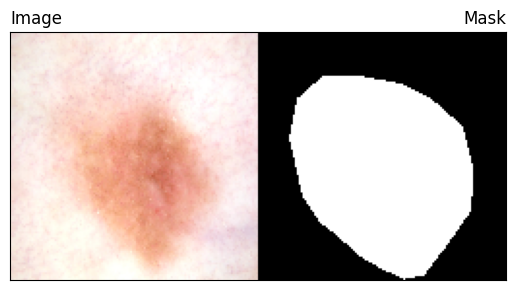

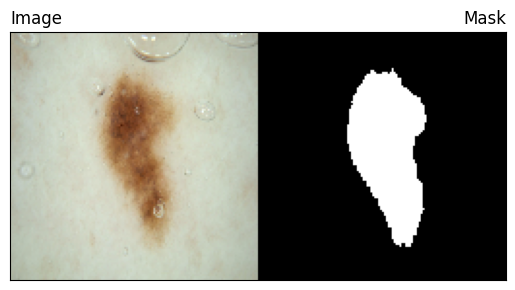

In [ ]:
def plot(img, mask):
  img = img.permute(1, 2, 0).numpy()
  mask = mask.permute(1, 2, 0).squeeze().numpy()
  mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
  mask = np.expand_dims(mask, axis=2)
  mask = np.repeat(mask, 3, axis=2)
  concatenated_img = np.concatenate((img, mask), axis=1)

  fig, ax = plt.subplots()
  ax.imshow(concatenated_img)
  ax.set_title('Image', loc='left')
  ax.set_title('Mask', loc='right')

  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xticklabels([])
  ax.set_yticklabels([])

  plt.show()

for i in range(5):
  img, mask = test_dataset[i]
  plot(img, mask)

In [ ]:
img, mask = test_dataset[19]
print(img.shape, mask.shape)

torch.Size([3, 128, 128]) torch.Size([1, 128, 128])


In [ ]:
# import MobileNetv2 for encoder
import torchvision.models as models
mobilenet = models.mobilenet_v2(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
class Segmentor(nn.Module):
    def __init__(self):
        super(Segmentor, self).__init__()

        # Load MobileNetV2 pretrained on ImageNet
        self.encoder = models.mobilenet_v2(pretrained=True).features

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1280, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Conv2d(32, 1, kernel_size=1),
            #nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)

        return x

In [ ]:
class SegmentationScore:
    @staticmethod
    def dice_score(y_pred, y_true):

        y_pred_flat = y_pred.view(-1)
        y_true_flat = y_true.view(-1)

        intersection = torch.sum(y_true_flat * y_pred_flat)
        union = torch.sum(y_true_flat) + torch.sum(y_pred_flat)

        dice = (2.0 * intersection) / (union)

        return dice

    @staticmethod
    def iou_score(y_pred, y_true):
        y_pred_flat = y_pred.view(-1)
        y_true_flat = y_true.view(-1)

        intersection = torch.sum(y_true_flat * y_pred_flat)
        union = torch.sum(y_true_flat) + torch.sum(y_pred_flat) - intersection

        iou = (intersection / union)

        return iou

In [ ]:
class ModelTrainer:
    def __init__(self, model, criterion,dice_criterion,iou_criterion, optimizer, scaler, train_loader, test_loader):
        self.model = model
        self.criterion = criterion
        self.dice_criterion = dice_criterion
        self.iou_criterion = iou_criterion
        self.optimizer = optimizer
        self.scaler = scaler
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.train_losses = []
        self.test_losses = []
        self.dice_scores = []
        self.iou_scores = []

    def train(self, total_epochs):
        for epoch in range(total_epochs):
            self.model.train()
            train_loss = 0.0
            test_loss = 0.0
            dice_score = 0.0
            iou_score = 0.0

            train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)

            for batch_idx, (images, masks) in train_loop:
                images, masks = images.to(device), masks.to(device)

                self.optimizer.zero_grad()

                with torch.cuda.amp.autocast():
                    outputs = self.model(images)
                    loss = self.criterion(outputs, masks)

                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()

                train_loss += loss.item()

            train_loss /= len(self.train_loader)
            self.train_losses.append(train_loss)

            self.model.eval()
            with torch.no_grad():
                for batch_idx, (images, masks) in enumerate(self.test_loader):
                    images, masks = images.to(device), masks.to(device)
                    #print(masks)
                    outputs = self.model(images)
                    #testing loss

                    loss = self.criterion(outputs, masks)
                    test_loss += loss.item()

                    m=nn.Sigmoid()
                    outputs1=m(outputs)
                    #print(outputs1)
                    outputs1[outputs1< 0.5] = 0
                    outputs1[outputs1>= 0.5] = 1

                    #dice score
                    score = self.dice_criterion(outputs1, masks)
                    dice_score += score.item()

                    #iou score
                    score = self.iou_criterion(outputs1, masks)
                    iou_score += score.item()

                test_loss /= len(self.test_loader)
                self.test_losses.append(test_loss)

                dice_score /= len(self.test_loader)
                self.dice_scores.append(dice_score)

                iou_score /= len(self.test_loader)
                self.iou_scores.append(iou_score)

            print(f"Epoch [{epoch+1}/{total_epochs}] || Train Loss: {train_loss:.4f} || Test/Val Loss: {test_loss:.4f}")
            print(f"Epoch [{epoch+1}/{total_epochs}] || Dice Score: {dice_score:.4f} || IoU Score: {iou_score:.4f}")

        return self.model

    def plot_losses(self):
        plt.figure()
        plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label='Training Loss')
        plt.plot(range(1, len(self.test_losses) + 1), self.test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Test Loss over Epochs')
        plt.legend()
        plt.show()

    def plot_dice_score(self):
        plt.figure()
        plt.plot(range(1, len(self.dice_scores) + 1), self.dice_scores, label='Dice Scores')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.title('Dice Score over Epochs')
        plt.legend()
        plt.show()

    def plot_iou_score(self):
        plt.figure()
        plt.plot(range(1, len(self.iou_scores) + 1), self.iou_scores, label='IoU Score')
        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.title('IoU Score over Epochs')
        plt.legend()
        plt.show()

In [ ]:
#Off shelf learning
encoder_lr= 0
decoder_lr = 0.0001
Total_epochs= 20
seg = Segmentor().to(device)
criterion = nn.BCEWithLogitsLoss()
eval_criterion = SegmentationScore()
dice_criterion = eval_criterion.dice_score
iou_criterion = eval_criterion.iou_score
optimizer = optim.Adam([
    {'params': seg.encoder.parameters(), 'lr': encoder_lr},
    {'params': seg.decoder.parameters(), 'lr': decoder_lr}
])
scaler = torch.cuda.amp.GradScaler()

In [ ]:
trainer = ModelTrainer(seg, criterion,dice_criterion,iou_criterion ,optimizer, scaler, train_loader, test_loader)
trained_model=trainer.train(Total_epochs)
trainer.plot_losses()
trainer.plot_dice_score()
trainer.plot_iou_score()

Epoch [1/20] || Train Loss: 0.5516 || Test/Val Loss: 0.5305
Epoch [1/20] || Dice Score: 0.5248 || IoU Score: 0.4107


Epoch [2/20] || Train Loss: 0.4492 || Test/Val Loss: 0.3824
Epoch [2/20] || Dice Score: 0.5466 || IoU Score: 0.4430


Epoch [3/20] || Train Loss: 0.3928 || Test/Val Loss: 0.3518
Epoch [3/20] || Dice Score: 0.6092 || IoU Score: 0.4958


Epoch [4/20] || Train Loss: 0.3613 || Test/Val Loss: 0.3360
Epoch [4/20] || Dice Score: 0.6370 || IoU Score: 0.5189


Epoch [5/20] || Train Loss: 0.3296 || Test/Val Loss: 0.3021
Epoch [5/20] || Dice Score: 0.5933 || IoU Score: 0.4830


Epoch [6/20] || Train Loss: 0.3210 || Test/Val Loss: 0.2846
Epoch [6/20] || Dice Score: 0.6338 || IoU Score: 0.5196


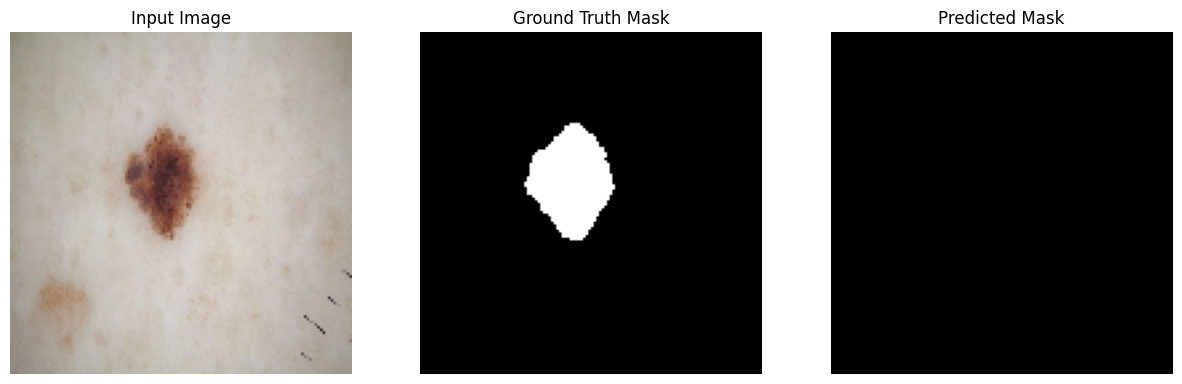

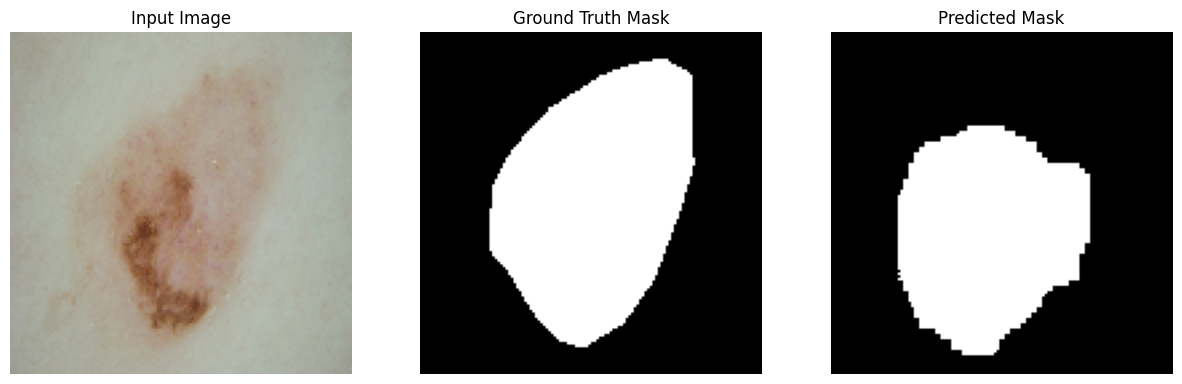

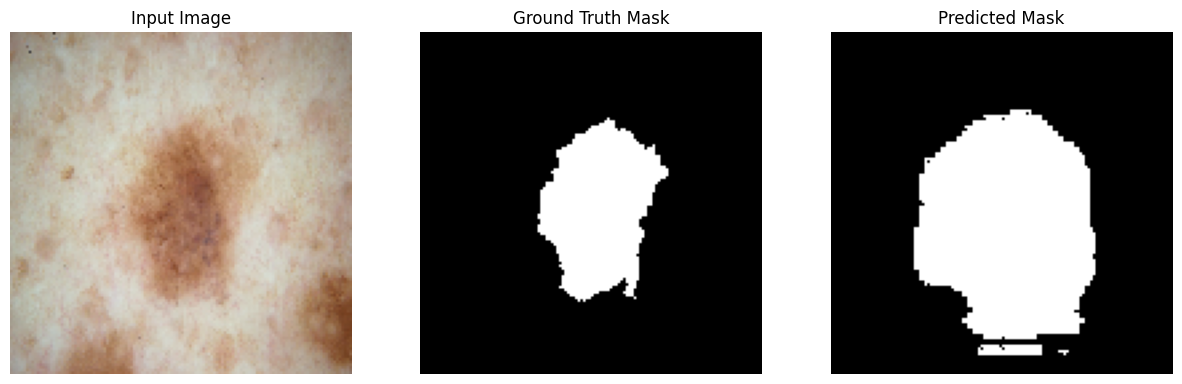

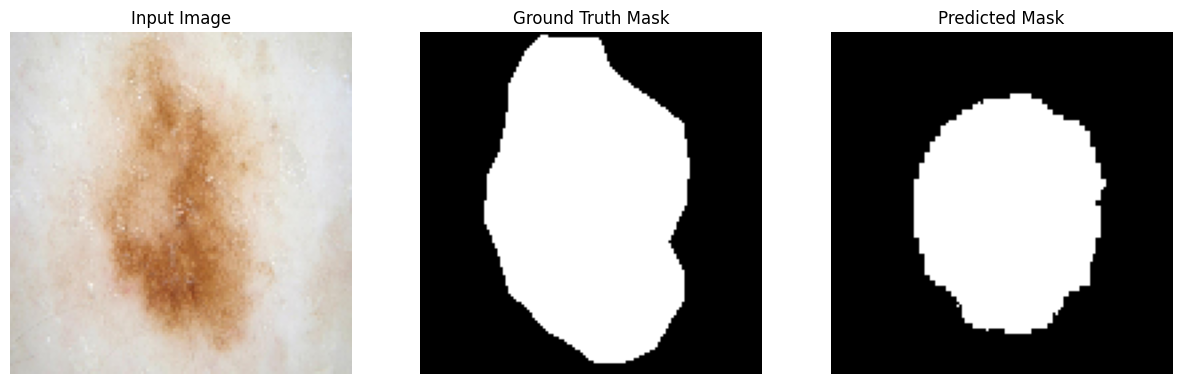

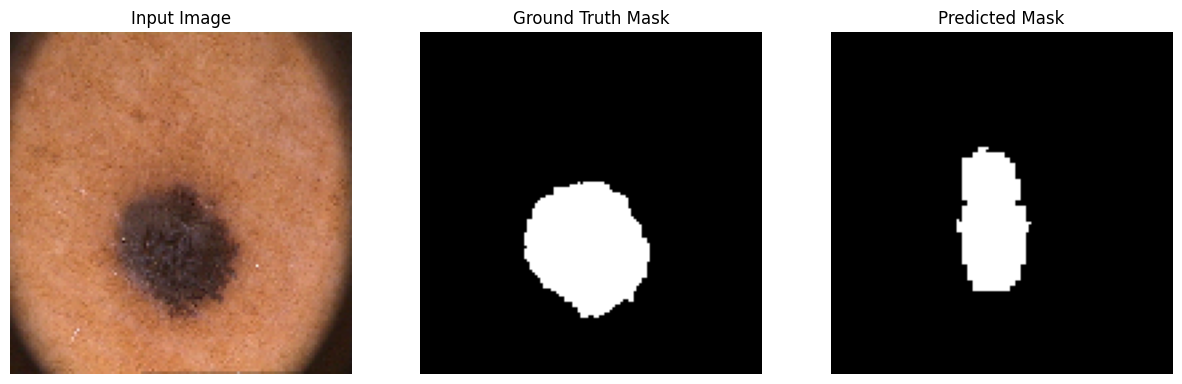

In [ ]:
trained_model.eval()

sample_indices = np.random.choice(len(test_loader.dataset), 5, replace=False)

for idx in sample_indices:
    image, mask = test_loader.dataset[idx]

    #print(mask)

    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = trained_model(image.to(device))
        #print(outputs)
        m = nn.Sigmoid()
        outputs = m(outputs)
    outputs[outputs< 0.5] = 0
    outputs[outputs >= 0.5] = 1

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image.squeeze().permute(1, 2, 0))
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')
    axes[2].imshow(outputs.squeeze().cpu().numpy(), cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()

In [ ]:
#Fine Tuning of Segmentation
encoder_lr= 0.001
decoder_lr = 0.001
Total_epochs= 20
seg = Segmentor().to(device)
criterion = nn.BCEWithLogitsLoss()
eval_criterion = SegmentationScore()
dice_criterion = eval_criterion.dice_score
iou_criterion = eval_criterion.iou_score
optimizer = optim.Adam([
    {'params': seg.encoder.parameters(), 'lr': encoder_lr},
    {'params': seg.decoder.parameters(), 'lr': decoder_lr}
])
scaler = torch.cuda.amp.GradScaler()

Epoch [1/20] || Train Loss: 0.5090 || Test/Val Loss: 0.6663
Epoch [1/20] || Dice Score: 0.6046 || IoU Score: 0.4653


Epoch [2/20] || Train Loss: 0.3557 || Test/Val Loss: 0.3347
Epoch [2/20] || Dice Score: 0.7383 || IoU Score: 0.6136


Epoch [3/20] || Train Loss: 0.2775 || Test/Val Loss: 0.2392
Epoch [3/20] || Dice Score: 0.8289 || IoU Score: 0.7253


Epoch [4/20] || Train Loss: 0.2365 || Test/Val Loss: 0.2053
Epoch [4/20] || Dice Score: 0.8496 || IoU Score: 0.7562


Epoch [5/20] || Train Loss: 0.2321 || Test/Val Loss: 0.2114
Epoch [5/20] || Dice Score: 0.8270 || IoU Score: 0.7260


Epoch [6/20] || Train Loss: 0.1948 || Test/Val Loss: 0.2198
Epoch [6/20] || Dice Score: 0.8375 || IoU Score: 0.7372


Epoch [7/20] || Train Loss: 0.1747 || Test/Val Loss: 0.1587
Epoch [7/20] || Dice Score: 0.8724 || IoU Score: 0.7874


Epoch [8/20] || Train Loss: 0.1679 || Test/Val Loss: 0.1623
Epoch [8/20] || Dice Score: 0.8695 || IoU Score: 0.7796


Epoch [9/20] || Train Loss: 0.1499 || Test/Val Loss: 0.1524
Epoch [9/20] || Dice Score: 0.8728 || IoU Score: 0.7889


Epoch [10/20] || Train Loss: 0.1408 || Test/Val Loss: 0.1376
Epoch [10/20] || Dice Score: 0.8768 || IoU Score: 0.7908


Epoch [11/20] || Train Loss: 0.1284 || Test/Val Loss: 0.1481
Epoch [11/20] || Dice Score: 0.8804 || IoU Score: 0.7980


Epoch [12/20] || Train Loss: 0.1414 || Test/Val Loss: 0.1535
Epoch [12/20] || Dice Score: 0.8742 || IoU Score: 0.7898


Epoch [13/20] || Train Loss: 0.1398 || Test/Val Loss: 0.1409
Epoch [13/20] || Dice Score: 0.8795 || IoU Score: 0.7946


Epoch [14/20] || Train Loss: 0.1327 || Test/Val Loss: 0.1375
Epoch [14/20] || Dice Score: 0.8748 || IoU Score: 0.7888


Epoch [15/20] || Train Loss: 0.1305 || Test/Val Loss: 0.1285
Epoch [15/20] || Dice Score: 0.8860 || IoU Score: 0.8051


Epoch [16/20] || Train Loss: 0.1214 || Test/Val Loss: 0.1347
Epoch [16/20] || Dice Score: 0.8852 || IoU Score: 0.8041


Epoch [17/20] || Train Loss: 0.1122 || Test/Val Loss: 0.1203
Epoch [17/20] || Dice Score: 0.8932 || IoU Score: 0.8161


Epoch [18/20] || Train Loss: 0.1063 || Test/Val Loss: 0.1204
Epoch [18/20] || Dice Score: 0.8923 || IoU Score: 0.8162


Epoch [19/20] || Train Loss: 0.1022 || Test/Val Loss: 0.1509
Epoch [19/20] || Dice Score: 0.8688 || IoU Score: 0.7834


Epoch [20/20] || Train Loss: 0.1138 || Test/Val Loss: 0.1460
Epoch [20/20] || Dice Score: 0.8825 || IoU Score: 0.7999


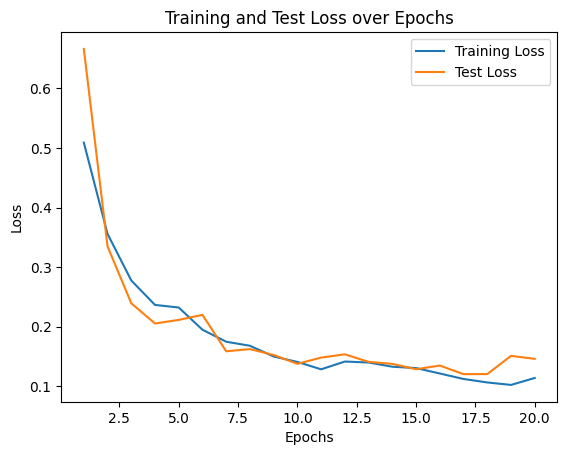

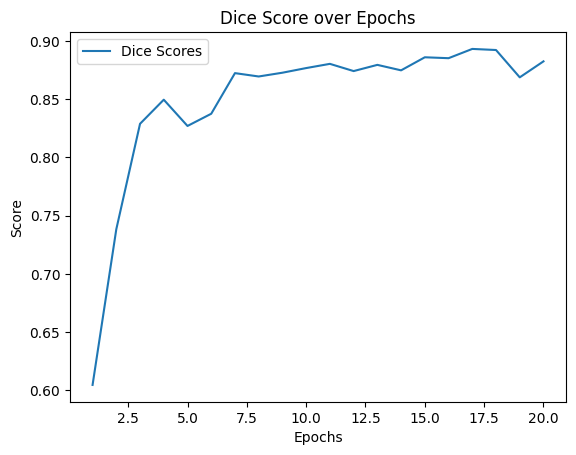

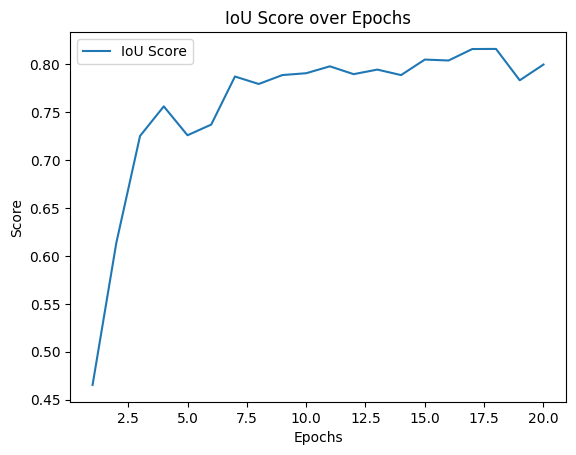

In [ ]:
trainer = ModelTrainer(seg, criterion,dice_criterion,iou_criterion ,optimizer, scaler, train_loader, test_loader)
finetuned_model=trainer.train(Total_epochs)
trainer.plot_losses()
trainer.plot_dice_score()
trainer.plot_iou_score()

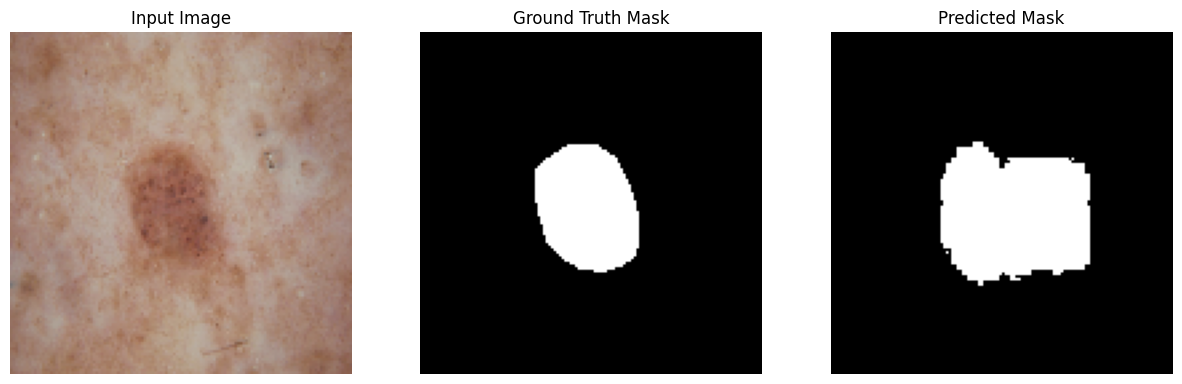

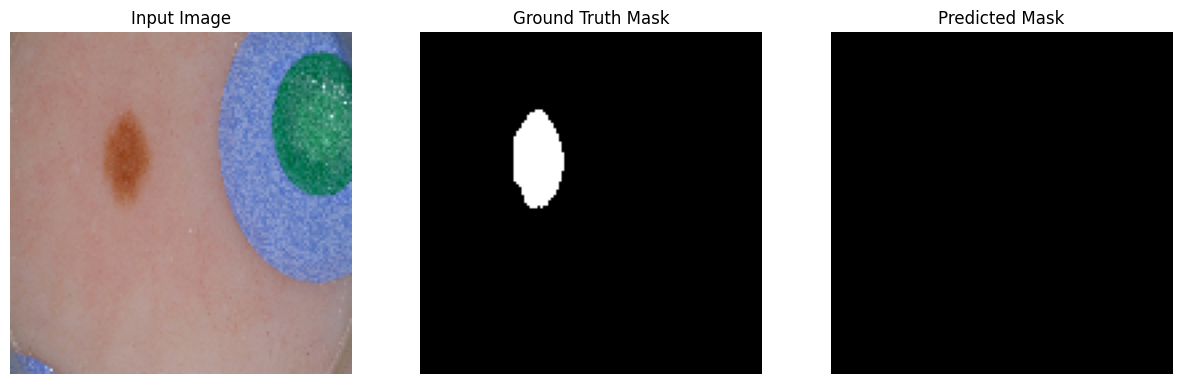

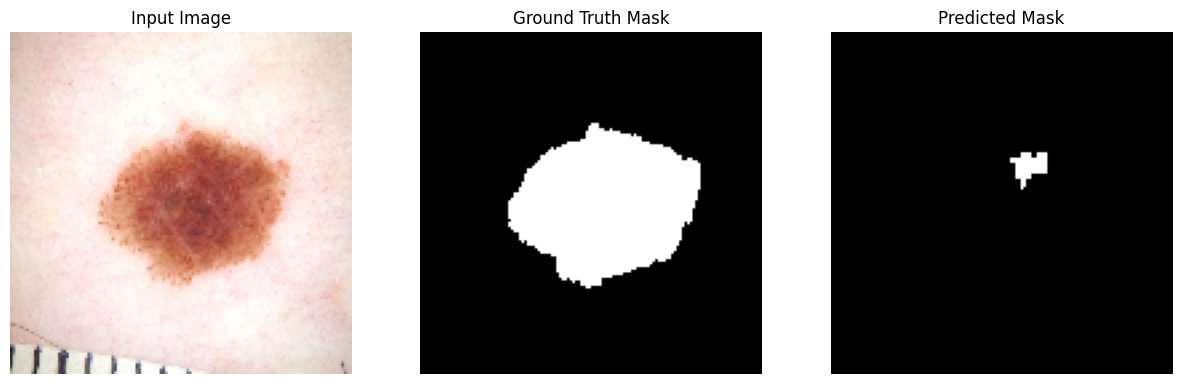

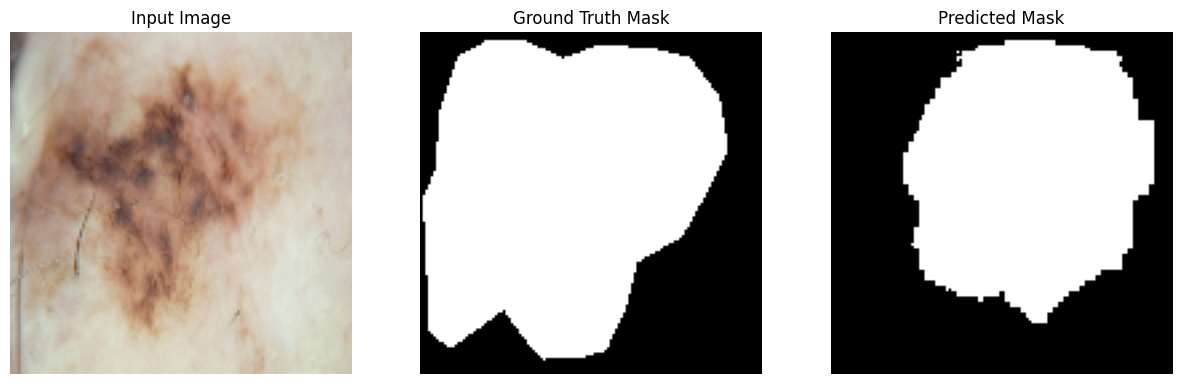

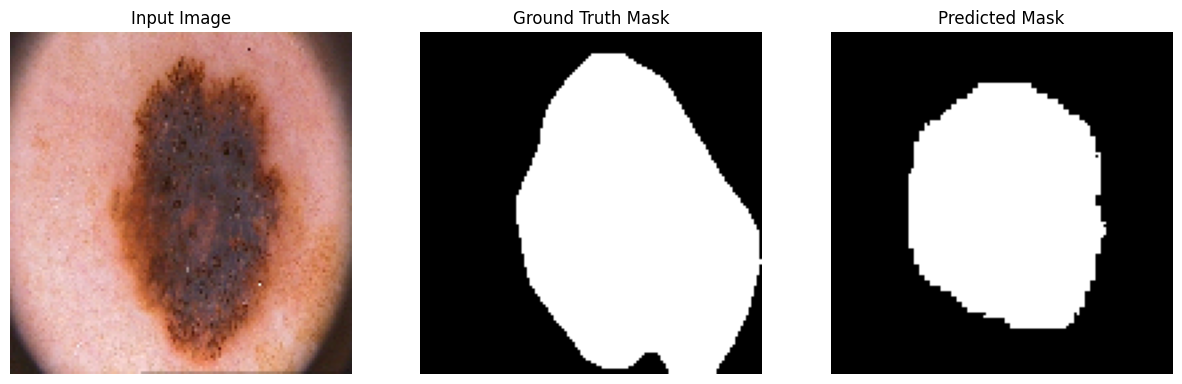

In [ ]:
finetuned_model.eval()

sample_indices = np.random.choice(len(test_loader.dataset), 5, replace=False)

for idx in sample_indices:
    image, mask = test_loader.dataset[idx]

    image = image.unsqueeze(0)
    with torch.no_grad():
        outputs = trained_model(image.to(device))
        m = nn.Sigmoid()
        outputs = m(outputs)

    outputs[outputs< 0.5] = 0
    outputs[outputs >= 0.5] = 1

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image.squeeze().permute(1, 2, 0))
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')
    axes[2].imshow(outputs.squeeze().cpu().numpy(), cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.show()